<a href="https://colab.research.google.com/github/Ransaka/data-ai-inspire/blob/main/3.%20Improving%20clustering%20with%20embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 24 11:16:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install datasets sentence-transformers --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━

# Loading dataset

In [3]:
import datasets

In [4]:
dataset = datasets.load_dataset("rajistics/million-headlines")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset = dataset['train'].shuffle().select(range(10_000))

In [6]:
headlines = dataset['headline_text']

# Understanding BERT output structure

## Loading model

In [7]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased", output_hidden_states = True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model.eval();

## Tokenizing input data

In [9]:
input_text = "NLP is awesome"

In [10]:
model_inputs = tokenizer(input_text, return_tensors='pt')

In [11]:
model_inputs

{'input_ids': tensor([[  101, 17953,  2361,  2003, 12476,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

## Extracting model hidden states

In [12]:
model_output = model(**model_inputs)

In [13]:
len(model_output['hidden_states'])

13

## Getting embeddings

In [14]:
model_output['hidden_states'][-1].shape

torch.Size([1, 6, 768])

In [15]:
embeddings = model_output['hidden_states'][-1][:,0]

In [16]:
embeddings.shape

torch.Size([1, 768])

## Example 01

In [17]:
corpus = ["King went to palace","Queen went to palace", "I went to home"]

In [18]:
embeddings_list = []

for text in corpus:
  model_inputs = tokenizer(text, return_tensors='pt')
  model_output = model(**model_inputs)
  embeddings = model_output['hidden_states'][-1][:,0].detach().numpy().flatten()
  embeddings_list.append(
      embeddings
  )

In [19]:
import pandas as pd
embeddings_df = pd.DataFrame(embeddings_list)

In [20]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.247859,-0.049982,0.381802,0.172069,-0.768444,-0.547361,1.061224,0.809480,0.033537,-0.221951,...,0.076021,-0.071470,0.206409,0.595277,0.088288,0.067730,0.187309,-0.816851,0.176415,-0.112965
1,-0.415582,-0.090590,0.556064,0.055692,-0.377571,-0.528098,0.943722,0.915218,-0.050548,-0.152093,...,-0.063782,-0.214634,0.074805,0.543698,0.180491,-0.295743,0.381786,-0.959844,0.202452,-0.050242
2,-0.102230,0.275489,-0.041937,-0.096318,-0.365377,-0.084229,0.374865,0.411745,0.145770,-0.407262,...,0.020537,-0.013249,0.189079,0.281788,0.213986,-0.268719,-0.093196,-0.175968,0.494571,0.359963


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [22]:
d = PCA(n_components=2).fit_transform(embeddings_df)

In [23]:
from scipy import spatial

king = embeddings_list[0]
queen = embeddings_list[1]
I = embeddings_list[2]

#cosine similarity between king and queen
1 - spatial.distance.cosine(king, queen)

0.939232349395752

In [24]:
from scipy import spatial

king = embeddings_list[0]
queen = embeddings_list[1]
I = embeddings_list[2]

#cosine similarity between king and I
1 - spatial.distance.cosine(king, I)

0.6880552768707275

# Extracting embeddings for 10_000 headlines

In [26]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("BAAI/bge-base-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
headline_embeddings = model.encode(headlines)

In [30]:
embedding_pca = PCA(n_components=2).fit_transform(headline_embeddings)

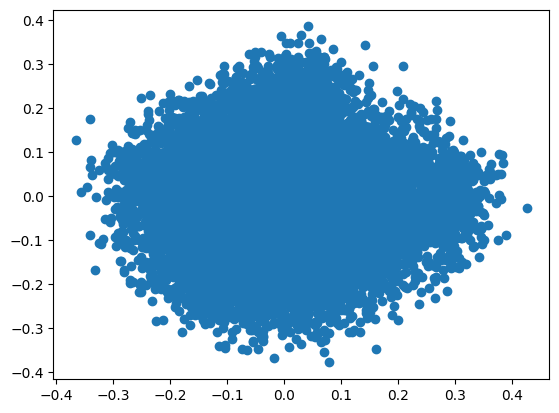

In [32]:
plt.scatter(embedding_pca[:,0], embedding_pca[:,1]);

In [34]:
from sklearn.cluster import KMeans

In [35]:
clusters = KMeans(n_clusters=8).fit_predict(headline_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


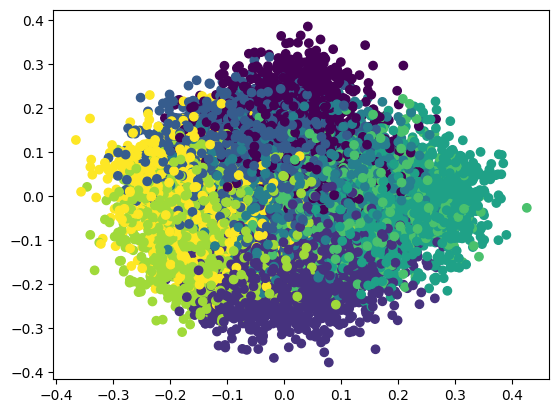

In [36]:
plt.scatter(embedding_pca[:,0], embedding_pca[:,1], c=clusters);

In [38]:
data = pd.DataFrame(data=headlines)

In [41]:
data['cluster'] = clusters

In [42]:
data

,0,cluster
0,dr rosemary bryant on ao,2
1,tara costigan killer marcus rappel transfered nsw,4
2,australias jobless rate rises,7
3,premier denies wood deal backflip,1
4,millions to be spent on taree roads,6
...,...,...
9995,key witness in bashir trial withdraws confession,5
9996,former mayor to retire from council,6
9997,residents unite to fight local development,6
9998,sa water security minister karlene maywald talks,6
